<a href="https://colab.research.google.com/github/srg9000/ibm_datascience_capstone/blob/main/Week4_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Battle of Neighborhoods
# Recommending the correct neighbourhood to a new home buyer

## Introduction (Problem statement and discussion):
Selecting a good home is not just about owning a place, the user also needs to consider facilities and services offered in the nearby region, such as snack bars, hotels, theaters etc.

<br>

To make this process easy, this project aims to be a recommendation engine based on user's input of desired services, currently in Neighbourhoods of Toronto. The intended approach is to create feature vectors of neighbourhoods and use them to train classifier which gives out top place (neighbourhood) which is close to the user's requirements.

<br>

This can be used by home buyers directly as well as real estate agents who make suggestions to their customers.


<hr>

**Stakeholders**: Home buyers and real estate agents


<hr>

## Description of data and its usage

Data required is the data for Neighbourhoods in Toronto and nearby venues.

- The neighbourhood data (PostalCodes mainly) will be scraped from public websites and then using FourSquare API, the corresponding venues and their categories will be extracted.

- The categories will then be converted to numerical features for all venues, and they will be mapped to the corresponding neighbourhoods. Using this, a kNN classifier will be trained. This can be treated as a classification with k=1 problem or as a Recommender system.

- For prediction, the user input will be converted to same features and a class will be extracted with probabilities, from that top 1 will be returned as suggestion.


<hr>

Data Sample: 
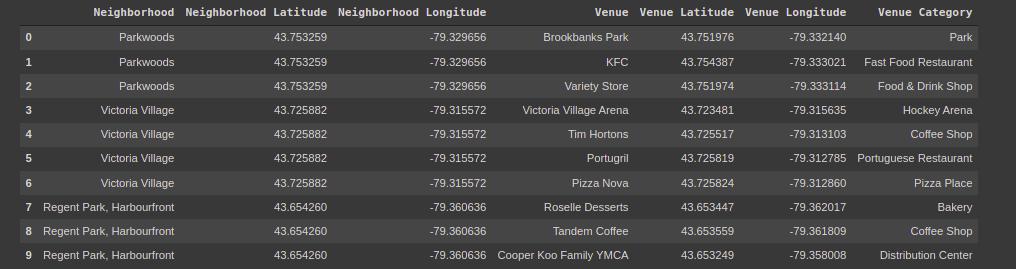

# Methodology

The extracted mappings of venue categories and neighbourhood will be mapped to a feature space. Features will be a vector of 1's and 0's where 1 represents that venue belonging to that category exists in the neighborhood, and 0 means it does not.

<br>

For inference, since training set only has 1 neighbourhood as class, KNN model with k=1 will be used. Theis can be improved if user location is also served as input but that has not been included as of now.

<br>

For inference, distance will be calculated only for values of input features which are positive, otherwise, other positive dimensions of known datapoints can increase the distance.

# Analysis and modeling

## Step 1: Scrape data

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
wiki_url = requests.get(url)
wiki_url

<Response [200]>

In [3]:
soup = BeautifulSoup(wiki_url.text)
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)

In [4]:
df

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East TorontoBusiness reply mail Processing Cen...,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [5]:
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [6]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [7]:
df = df.groupby(['PostalCode']).head()

In [8]:
df.Neighborhood.str.count("Not assigned").sum()

0

## Step 2: Get latitude and longitude using geocoder

In [9]:
!pip install geocoder

     |████████████████████████████████| 98 kB 5.3 MB/s 


In [10]:
import geocoder # import geocoder

lat_list = []
long_list = []

In [11]:
lat_long_df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv')

In [12]:
lat_long_df

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [13]:
lat_long_df.columns = ['PostalCode', 'Latitude','Longitude']
lat_long_df['PostalCode'] = lat_long_df['PostalCode'].astype(object)
df['PostalCode'] = df['PostalCode'].astype(object)

In [14]:
df = df.join(lat_long_df.set_index('PostalCode'), on='PostalCode')

In [15]:
df.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


## Step 3: Data preprocessing/wrangling and transformation

Extracting venue and categories using Foursquare API and geocoder

In [16]:
from geopy.geocoders import Nominatim

In [17]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("Toronto's coordinates: {}, {}.".format(latitude, longitude))

Toronto's coordinates: 43.6534817, -79.3839347.


In [18]:
import folium

# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        ).add_to(map_Toronto)  
    
map_Toronto

In [19]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version

In [22]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [23]:
import json
from pandas import json_normalize

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,KFC,Fast Food Restaurant,43.754387,-79.333021
2,Variety Store,Food & Drink Shop,43.751974,-79.333114


In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            print(requests.get(url).json()["response"])
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

In [26]:
toronto_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
5,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
6,Victoria Village,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place
7,"Regent Park, Harbourfront",43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
8,"Regent Park, Harbourfront",43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
9,"Regent Park, Harbourfront",43.654260,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center


In [27]:
toronto_venues.groupby('Neighborhood')['Venue'].count()

Neighborhood
Agincourt                                           4
Alderwood, Long Branch                              8
Bathurst Manor, Wilson Heights, Downsview North    21
Bayview Village                                     4
Bedford Park, Lawrence Manor East                  25
                                                   ..
Willowdale West                                     5
Willowdale, Newtonbrook                             1
Woburn                                              4
Woodbine Heights                                    8
York Mills West                                     3
Name: Venue, Length: 100, dtype: int64

In [237]:
len(toronto_venues['Venue Category'].unique())

274

In [238]:
toronto_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
...,...,...,...,...,...,...,...
2137,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Jim & Maria's No Frills,43.631152,-79.518617,Grocery Store
2138,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Islington Florist & Nursery,43.630156,-79.518718,Flower Shop
2139,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Koala Tan Tanning Salon & Sunless Spa,43.631370,-79.519006,Tanning Salon
2140,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Kingsway Boxing Club,43.627254,-79.526684,Gym


All 274  different venues will become features and Neighbourhood will become target

In [239]:
toronto_venues_ohe = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

In [240]:
# Add neighborhood
toronto_venues_ohe['Neighborhood'] = toronto_venues['Neighborhood']

In [241]:
toronto_venues_ohe = toronto_venues_ohe[['Neighborhood'] + [i for i in toronto_venues_ohe.columns if i!= 'Neighborhood']]

In [242]:
toronto_venues_ohe.head()

,Neighborhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,...,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Group all venues for a neighbour hood and aggregate all venue categories

In [245]:
toronto_venues_ohe_grouped = toronto_venues_ohe.groupby('Neighborhood').sum().reset_index()

In [246]:
toronto_venues_ohe_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,...,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bayview Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Bedford Park, Lawrence Manor East",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


Venue categories are not just one hot encoded anymore, after sum, the values can be greater than one (Multiple venues of same category), which will also increase the distance from user's input vector.
A good way to mitigate this will be clipping as average/scaling etc will reduce the score for available services.

In [247]:
toronto_venues_ohe_grouped[[i for i in toronto_venues_ohe.columns if i!= 'Neighborhood']].clip(lower=0, upper=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:7358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._clip_with_scalar(lower, upper, inplace=inplace)


In [248]:
toronto_venues_ohe_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,...,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bayview Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Bedford Park, Lawrence Manor East",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


Separate features and target (Neighborhood)

In [249]:
neighborhood = toronto_venues_ohe_grouped[['Neighborhood']]
category_features = toronto_venues_ohe_grouped[[i for i in toronto_venues_ohe.columns if i!= 'Neighborhood']]

In [250]:
# Save order of categories (Features)
category_order = category_features.columns

## Step 4: Creating a model

In [251]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, f1_score

In [252]:
def distance_metric(x, y):
    """
    Only consider features which are non zero for 
    x (input) and ignore other positive features of datapoint and
    then calculate euclidean distance.
    """
    x_mask = x!=0
    y = y*x_mask
    return np.linalg.norm(y-x, 1)

In [294]:
clf = KNeighborsClassifier(n_neighbors=1, metric=distance_metric)
clf.fit(category_features, neighborhood)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30,
                     metric=<function distance_metric at 0x7f040c9d04d0>,
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

## Step 5: model testing and evaluation

We only need to consider services which are available

In [295]:
outputs = clf.predict(category_features)
print("Recall score: ", recall_score(np.array(neighborhood).ravel(), np.array(outputs).ravel(), average='micro'))
print("F1 score: ", f1_score(np.array(neighborhood).ravel(), np.array(outputs).ravel(), average='micro'))

Recall score:  0.91
F1 score:  0.91


Test on ungrouped data

In [297]:
test_neighbourhood = toronto_venues_ohe['Neighborhood']
test_features = toronto_venues_ohe[[i for i in toronto_venues_ohe.columns if i != 'Neighborhood']]
test_features = test_features[category_order]
outputs = clf.predict(test_features)
print("Recall score: ", recall_score(np.array(test_neighbourhood).ravel(), np.array(outputs).ravel(), average='macro'))
print("F1 score: ", f1_score(np.array(test_neighbourhood).ravel(), np.array(outputs).ravel(), average='macro'))

Recall score:  0.73697639214539
F1 score:  0.6930395072369206


## Sample usage

Get categories from user and transform them

In [282]:
# User input
input_categories = ["Women's Store",'American Restaurant', 'Airport', 'Wine Bar']
input_vector = [1 if i in input_categories else 0 for i in category_order]

In [284]:
len(input_vector)

273

In [285]:
clf.predict([input_vector])

array(['Fairview, Henry Farm, Oriole'], dtype=object)

# Results and Discussion

Test results are not as great compared to training results, this is due to the fact that selected features are not very expressive / are binary and number of samples for each class is 1. This can be improved by including location information, For example, instead of restaurant being scored as 1, it can be scaled to express the distance from user's location.

<br>

For this, user's location will be required as input.

# Conclusion

The purpose of this project was to create a recommendation engine which recommends a neighborhood to user based on availability of given facilities.

<br>

Here, an approach based on classification is given for recommendation of a neighborhood that best provides the facilities required by the user.

<br>

Final decission on optimal location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.